In [58]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from scipy import stats
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.ensemble import (
    RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier,
    VotingClassifier, RandomForestRegressor, ExtraTreesClassifier,
    StackingClassifier
)
from sklearn.linear_model import (
    LogisticRegression, SGDClassifier
)
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve, auc,
    precision_recall_curve, average_precision_score,
    precision_score, recall_score, f1_score,
    log_loss
)
from sklearn.model_selection import (
    train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
)
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, StandardScaler
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics, linear_model, neighbors, ensemble, tree
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.pipeline import make_pipeline

from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours
from imblearn.over_sampling import SMOTE

import pickle

os.environ['LOKY_MAX_CPU_COUNT'] = '4'

import xgboost as xgb
from xgboost import XGBClassifier

from collections import defaultdict


In [59]:
# Read the CSV file with specified data types
df = pd.read_csv('final_dataset.csv', low_memory=False)

In [60]:
print(df['manufactured_home_secured_property_type'].value_counts())

manufactured_home_secured_property_type
1.0    48651
0.0     1003
0.5       16
Name: count, dtype: int64


In [61]:
df.head()

,census_tract,action_taken,loan_type,lien_status,open_end_line_of_credit,loan_amount,combined_loan_to_value_ratio,interest_rate,total_loan_costs,origination_charges,...,applicant_ethnicity_1,co_applicant_ethnicity_1,applicant_race_1,applicant_race_2,co_applicant_race_1,co_applicant_race_2,applicant_sex,co_applicant_sex,applicant_age,co_applicant_age
0,0.745178,1.0,0.666667,0.0,1.0,0.011765,1.000000,0.333333,0.352941,0.0,...,1.0,1.0,1.0,0.0,1.0,0.093023,0.0,0.2,1.000000,0.571429
1,0.861853,1.0,0.333333,0.0,1.0,0.008824,0.400000,0.333333,0.352941,0.0,...,1.0,1.0,1.0,0.0,1.0,0.093023,0.2,0.0,0.428571,0.428571
2,0.291341,1.0,0.333333,0.0,1.0,0.007059,0.466667,0.333333,0.352941,0.0,...,1.0,1.0,1.0,0.0,1.0,0.093023,0.0,0.2,0.571429,0.428571
3,0.799498,1.0,0.333333,0.0,1.0,0.002941,0.400000,0.333333,0.352941,0.0,...,1.0,1.0,0.0,0.0,0.0,0.093023,0.0,0.2,0.285714,0.285714
4,0.745178,1.0,0.000000,0.0,1.0,0.020000,0.000000,0.333333,0.352941,0.0,...,1.0,1.0,1.0,0.0,1.0,0.093023,0.0,0.2,0.285714,0.285714


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49670 entries, 0 to 49669
Data columns (total 34 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   census_tract                              49670 non-null  float64
 1   action_taken                              49670 non-null  float64
 2   loan_type                                 49670 non-null  float64
 3   lien_status                               49670 non-null  float64
 4   open_end_line_of_credit                   49670 non-null  float64
 5   loan_amount                               49670 non-null  float64
 6   combined_loan_to_value_ratio              49670 non-null  float64
 7   interest_rate                             49670 non-null  float64
 8   total_loan_costs                          49670 non-null  float64
 9   origination_charges                       49670 non-null  float64
 10  loan_term                         

In [63]:
random_state=42

In [66]:
df['total_loan_costs'].value_counts()

total_loan_costs
0.352941    23423
0.058824     3700
0.000000     3659
0.117647     2987
0.176471     2624
0.235294     2545
0.294118     2306
0.411765     1786
0.529412     1346
0.470588     1317
0.588235     1067
0.647059      946
0.705882      589
0.764706      476
0.823529      306
0.882353      248
0.941176      189
1.000000      156
Name: count, dtype: int64

In [8]:
from imblearn.over_sampling import SMOTE
import pandas as pd

# Define the minority classes for each column
minority_classes = {
    'applicant_sex': [0.2, 1.0, 0.4],
    'co_applicant_sex': [0.0, 1.0],
    'applicant_race_1': [0.0],
    'co_applicant_race_1': [0.0],
    'applicant_ethnicity_1': [0.0],
    'co_applicant_ethnicity_1': [0.0],
}

# Create a dictionary to store resampled datasets for each column
resampled_datasets = {}

# Create a new DataFrame to store the resampled data
resampled_df = df.copy()

# Iterate through the columns and apply SMOTE to each
for column in df.columns:
    if column in minority_classes:
        # Select the specific column
        selected_column = df[column].values.reshape(-1, 1)

        # Define y_min based on the minority class for this column
        y_min = [1 if value in minority_classes[column] else 0 for value in df[column]]

        # Apply SMOTE to the selected column with a reduced sampling strategy
        smote = SMOTE(sampling_strategy='auto', random_state=42)
        X_resampled, y_resampled = smote.fit_resample(selected_column, y_min)

        # Ensure that the resampled data has the same number of rows as the original DataFrame
        if len(X_resampled) > len(df):
            X_resampled = X_resampled[:len(df)]
            y_resampled = y_resampled[:len(df)]

        # Update the resampled data in the new DataFrame
        resampled_df[column] = X_resampled.flatten()

# Now, 'resampled_df' contains all 35 columns with the necessary resampling applied to specific columns


In [9]:
resampled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49670 entries, 0 to 49669
Data columns (total 34 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   census_tract                              49670 non-null  float64
 1   action_taken                              49670 non-null  float64
 2   loan_type                                 49670 non-null  float64
 3   lien_status                               49670 non-null  float64
 4   open_end_line_of_credit                   49670 non-null  float64
 5   loan_amount                               49670 non-null  float64
 6   combined_loan_to_value_ratio              49670 non-null  float64
 7   interest_rate                             49670 non-null  float64
 8   total_loan_costs                          49670 non-null  float64
 9   origination_charges                       49670 non-null  float64
 10  loan_term                         

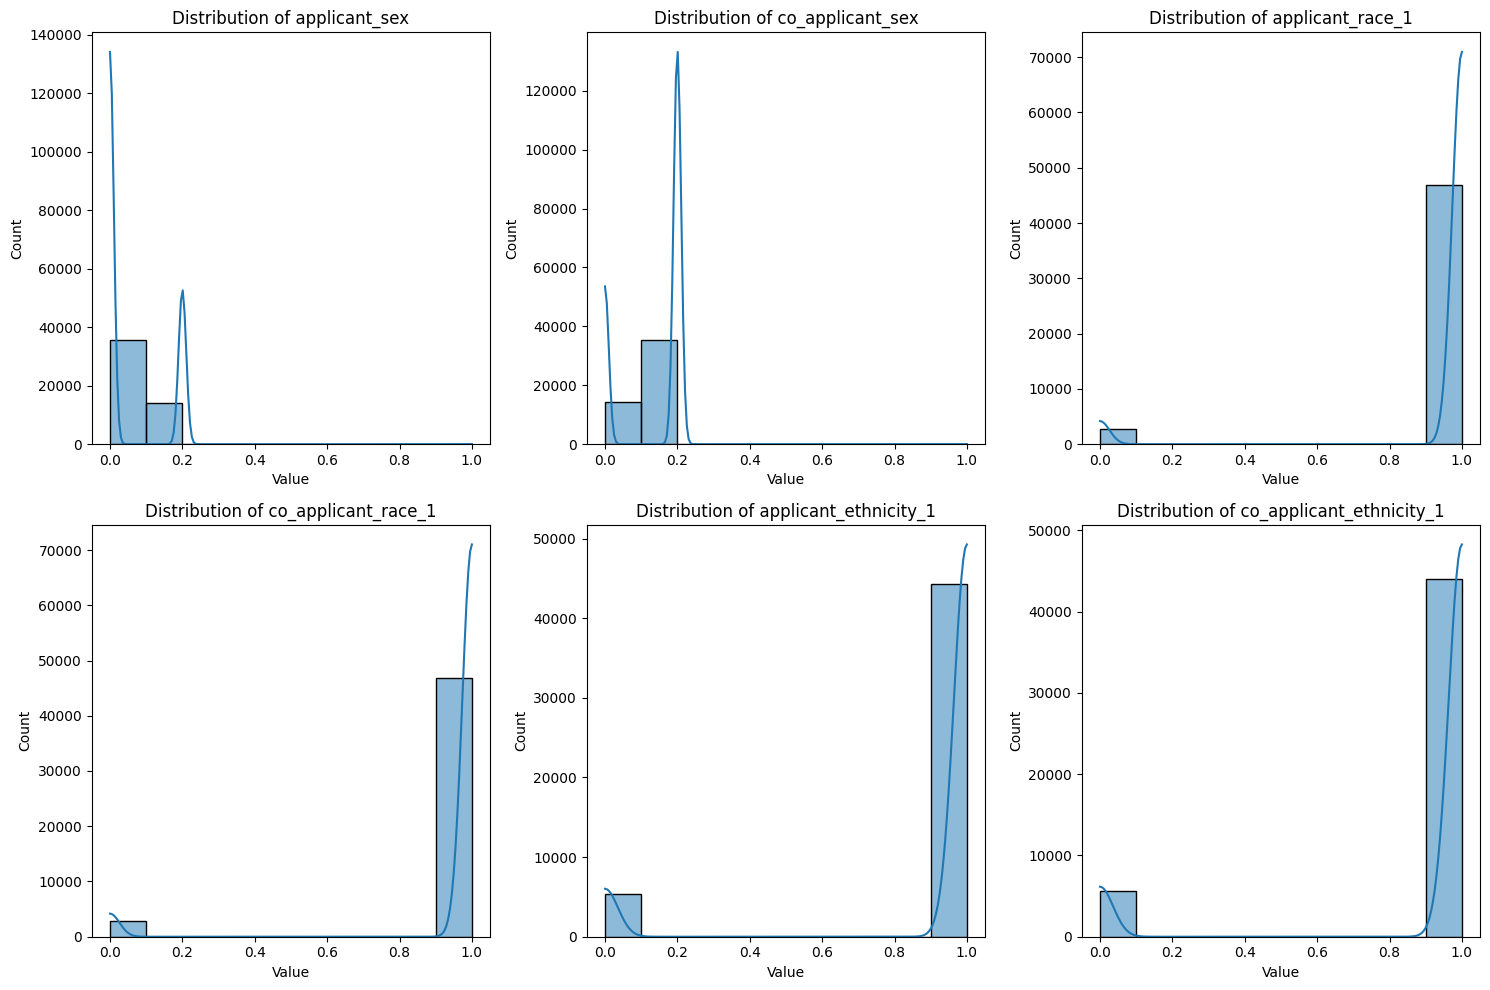

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a list of columns for which you want to plot the distribution
columns_to_plot = list(minority_classes.keys())

# Calculate the number of plots and rows
num_plots = len(columns_to_plot)
num_rows = (num_plots // 3) + (num_plots % 3)

# Create subplots
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))
axes = axes.ravel()

for i, column in enumerate(columns_to_plot):
    # Extract the resampled values for the current column from the resampled_df
    values = resampled_df[column]

    # Create a histogram plot
    g = sns.histplot(values, ax=axes[i], bins=10, kde=True)
    g.set_title(f'Distribution of {column}')
    g.set_xlabel("Value")
    g.set_ylabel("Count")

# Hide any empty subplots
for i in range(num_plots, num_rows * 3):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


# Logistic Regression

In [11]:
X = resampled_df.drop('action_taken', axis=1)
y = resampled_df['action_taken']

In [12]:
# Split your data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Now, split the training data into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [56]:
column_mapping = {i: col for i, col in enumerate(X_train.columns)}
column_mapping

{0: 'census_tract',
 1: 'loan_type',
 2: 'lien_status',
 3: 'open_end_line_of_credit',
 4: 'loan_amount',
 5: 'combined_loan_to_value_ratio',
 6: 'interest_rate',
 7: 'total_loan_costs',
 8: 'origination_charges',
 9: 'loan_term',
 10: 'negative_amortization',
 11: 'interest_only_payment',
 12: 'balloon_payment',
 13: 'other_nonamortizing_features',
 14: 'property_value',
 15: 'occupancy_type',
 16: 'manufactured_home_secured_property_type',
 17: 'manufactured_home_land_property_interest',
 18: 'total_units',
 19: 'income',
 20: 'debt_to_income_ratio',
 21: 'applicant_credit_score_type',
 22: 'co_applicant_credit_score_type',
 23: 'applicant_ethnicity_1',
 24: 'co_applicant_ethnicity_1',
 25: 'applicant_race_1',
 26: 'applicant_race_2',
 27: 'co_applicant_race_1',
 28: 'co_applicant_race_2',
 29: 'applicant_sex',
 30: 'co_applicant_sex',
 31: 'applicant_age',
 32: 'co_applicant_age'}

In [13]:
LR = LogisticRegression(penalty='l2', max_iter=1000, C=1.0) 
LR.fit(X_train, y_train)

y_predict = LR.predict(X_train) 
print(f"The accuracy for training: {LR.score(X_train, y_train)}") 
print(f"The accuracy for validation: {LR.score(X_val, y_val)}") 
print(f"F1 score for validation: {f1_score(LR.predict(X_val), y_val)}")

The accuracy for training: 0.8534667170001259
The accuracy for validation: 0.8452440865626573
F1 score for validation: 0.836826744494561


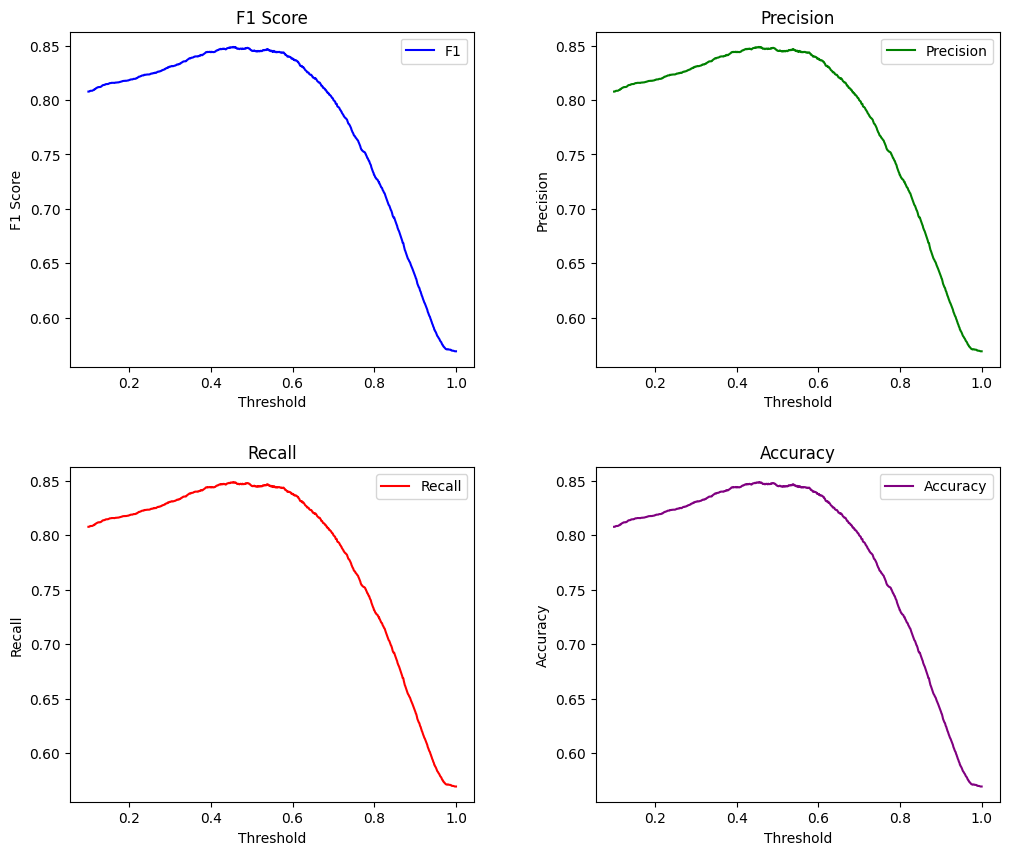

Logistic Regression Model best F1 score 0.849 at prob decision threshold >= 0.454


In [14]:
thresh_ps = np.linspace(.10, 1, 1000)
model_val_probs = LR.predict_proba(X_val)[:, 1]

f1_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
best_f1_score, best_thresh_p = 0, 0  # Initialize best F1 score and threshold

for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    prec_scores.append(precision_score(y_val, model_val_labels, average='micro'))
    rec_scores.append(recall_score(y_val, model_val_labels, average='micro'))
    f1 = f1_score(y_val, model_val_labels, average='micro')
    f1_scores.append(f1)
    acc_scores.append(accuracy_score(y_val, model_val_labels))
    
    if f1 > best_f1_score:
        best_f1_score = f1
        best_thresh_p = p

# Create subplots with 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Plot F1 score
axes[0, 0].plot(thresh_ps, f1_scores, label='F1', color='blue')
axes[0, 0].set_title('F1 Score')
axes[0, 0].set_xlabel('Threshold')
axes[0, 0].set_ylabel('F1 Score')

# Plot Precision
axes[0, 1].plot(thresh_ps, prec_scores, label='Precision', color='green')
axes[0, 1].set_title('Precision')
axes[0, 1].set_xlabel('Threshold')
axes[0, 1].set_ylabel('Precision')

# Plot Recall
axes[1, 0].plot(thresh_ps, rec_scores, label='Recall', color='red')
axes[1, 0].set_title('Recall')
axes[1, 0].set_xlabel('Threshold')
axes[1, 0].set_ylabel('Recall')

# Plot Accuracy
axes[1, 1].plot(thresh_ps, acc_scores, label='Accuracy', color='purple')
axes[1, 1].set_title('Accuracy')
axes[1, 1].set_xlabel('Threshold')
axes[1, 1].set_ylabel('Accuracy')

# Add legends to each subplot
for ax in axes.flatten():
    ax.legend()

# Display the plots
plt.show()


print('Logistic Regression Model best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))


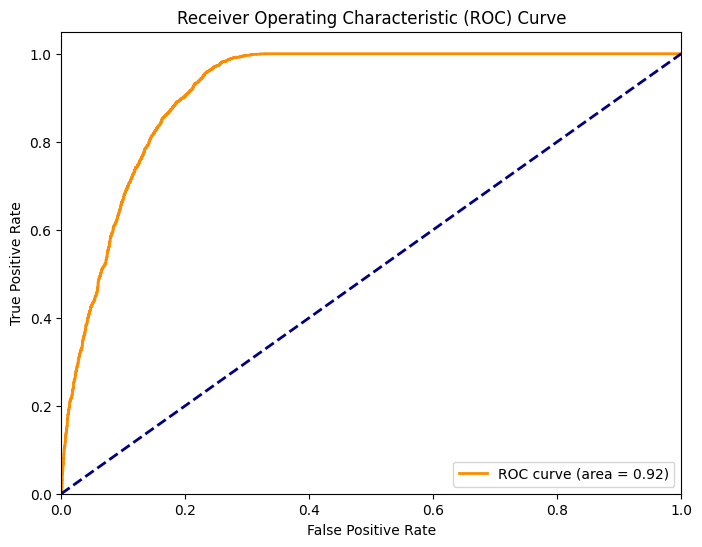

In [15]:
# Get the predicted probabilities for the positive class
model_val_probs = LR.predict_proba(X_val)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_val, model_val_probs)

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_val, model_val_probs)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [16]:
y_predict = (LR.predict_proba(X_train)[:, 1] >= 0.65)

print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_train, y_predict), 
                                                     recall_score(y_train, y_predict)))

Default threshold:
Precision: 0.8313,   Recall: 0.7644


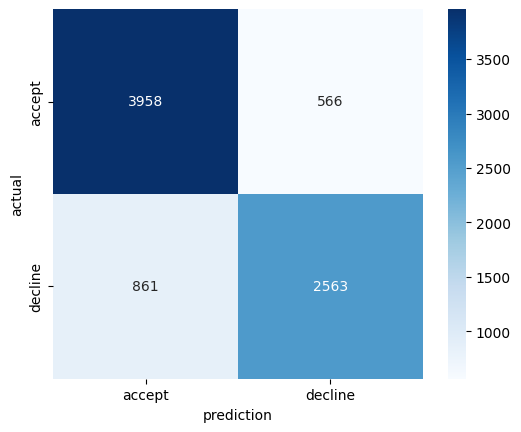

In [17]:
y_predict = (LR.predict_proba(X_val)[:, 1] >= 0.65)

confusion = confusion_matrix(y_val, y_predict)

sns.heatmap(confusion , cmap = plt.cm.Blues, annot = True , square = True , fmt = 'd',
           xticklabels = ['accept','decline'],
           yticklabels = ['accept','decline']);
plt.xlabel('prediction')
plt.ylabel('actual');

Conclusion: clearly overfitting. 

# KNeighborsClassifier

In [18]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Now, you can calculate the accuracy and F1 score
print('The accuracy for training : ', knn.score(X_train, y_train))
print('The accuracy for validation: ', knn.score(X_val, y_val))
print('F1_score for train: ', f1_score(knn.predict(X_train), y_train))
print('F1_score for validation: ', f1_score(knn.predict(X_val), y_val))

The accuracy for training :  0.9321127469485341
The accuracy for validation:  0.8764469048817313
F1_score for train:  0.9267829273257786
F1_score for validation:  0.8683646112600536


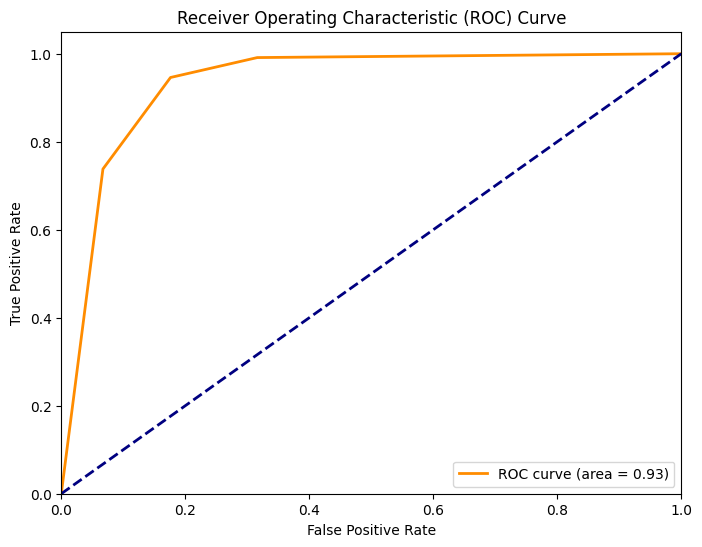

In [19]:
# Get the predicted probabilities for the positive class
model_val_probs = knn.predict_proba(X_val)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_val, model_val_probs)

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_val, model_val_probs)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [20]:
y_predict = (knn.predict_proba(X_train)[:, 1] >= 0.65)

print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_train, y_predict), 
                                                     recall_score(y_train, y_predict)))

Default threshold:
Precision: 0.8803,   Recall: 0.9785


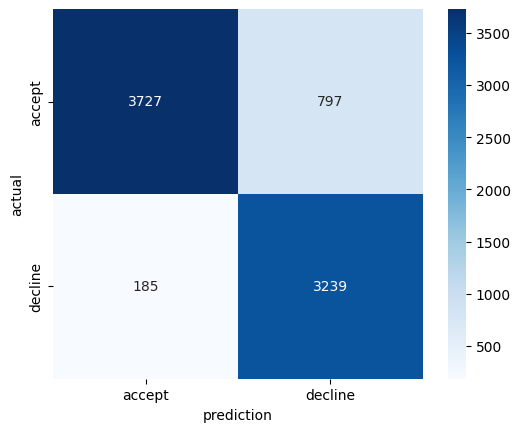

In [21]:
y_predict = (knn.predict_proba(X_val)[:, 1] >= 0.65)

confusion = confusion_matrix(y_val, y_predict)

sns.heatmap(confusion , cmap = plt.cm.Blues, annot = True , square = True , fmt = 'd',
           xticklabels = ['accept','decline'],
           yticklabels = ['accept','decline']);
plt.xlabel('prediction')
plt.ylabel('actual');

Conclusion: clearly overfitting. 

# Naive Bayes

In [22]:
Gaussian = GaussianNB()
Gaussian.fit(X_train, y_train)
print('The accuracy for training : ',Gaussian.score(X_train,y_train))
print('The accuracy for validation: ',Gaussian.score(X_val,y_val))
print('f1_score for train: ',f1_score(Gaussian.predict(X_train), y_train))
print('f1_score for validation: ',f1_score(Gaussian.predict(X_val), y_val))

The accuracy for training :  0.7926261482320373
The accuracy for validation:  0.7922747861097131
f1_score for train:  0.6934523809523809
f1_score for validation:  0.6843815714012618


# Ada Boost Classifier

In [23]:
AB_CLF = AdaBoostClassifier(n_estimators=50, random_state=random_state)
AB_CLF.fit(X_train , y_train)
print('The accuracy for training : ',AB_CLF.score(X_train,y_train))
print('The accuracy for validation: ',AB_CLF.score(X_val,y_val))
print('f1_score for train: ',f1_score(AB_CLF.predict(X_train), y_train))
print('f1_score for validation: ',f1_score(AB_CLF.predict(X_val), y_val))

The accuracy for training :  0.9846797533660501
The accuracy for validation:  0.9846502264720685
f1_score for train:  0.9828539238812801
f1_score for validation:  0.982496413199426


# Stochastic Gradient Descent Algorithm

In [24]:
SG_PIP_CLF = make_pipeline(StandardScaler(),
                     SGDClassifier(max_iter=100, tol=1e-3))
SG_PIP_CLF.fit(X_train , y_train)
print('The accuracy for training : ',SG_PIP_CLF.score(X_train,y_train))
print('The accuracy for validation: ',SG_PIP_CLF.score(X_val,y_val))
print('f1_score for train: ',f1_score(SG_PIP_CLF.predict(X_train), y_train))
print('f1_score for validation: ',f1_score(SG_PIP_CLF.predict(X_val), y_val))

The accuracy for training :  0.8912482697873412
The accuracy for validation:  0.8896577755410167
f1_score for train:  0.8878507704785076
f1_score for validation:  0.8844684494796469


# XGBoost (eXtreme Gradient Boosting) - this takes a very long time!

In [25]:
# Add early stopping
early_stopping_rounds = 3

xgb_model1 = xgb.XGBClassifier(early_stopping_rounds=early_stopping_rounds)

parameters = {
    'nthread': [4],
    'objective': ['binary:logistic'],
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.5, 0.7, 0.9],
    'colsample_bytree': [0.7],
    'n_estimators': [8000, 9000, 10000],
    'missing': [-999],
    'seed': [1337],
    'eval_metric': ['logloss'],
}

# Use 3-fold cross-validation
clf = GridSearchCV(xgb_model1, parameters, n_jobs=3,
                   cv=KFold(n_splits=3, shuffle=True, random_state=random_state),
                   scoring='neg_log_loss',  
                   verbose=4, refit=True)


# Implement early stopping
eval_set = [(X_val, y_val)]
clf.fit(X_train, y_train, eval_set=eval_set)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[0]	validation_0-logloss:0.58965
[1]	validation_0-logloss:0.45270
[2]	validation_0-logloss:0.36082
[3]	validation_0-logloss:0.29669
[4]	validation_0-logloss:0.26995
[5]	validation_0-logloss:0.22541
[6]	validation_0-logloss:0.19115
[7]	validation_0-logloss:0.16475
[8]	validation_0-logloss:0.14703
[9]	validation_0-logloss:0.13592
[10]	validation_0-logloss:0.11981
[11]	validation_0-logloss:0.11066
[12]	validation_0-logloss:0.10351
[13]	validation_0-logloss:0.09436
[14]	validation_0-logloss:0.08719
[15]	validation_0-logloss:0.08356
[16]	validation_0-logloss:0.08044
[17]	validation_0-logloss:0.07773
[18]	validation_0-logloss:0.07557
[19]	validation_0-logloss:0.07196
[20]	validation_0-logloss:0.06910
[21]	validation_0-logloss:0.06677
[22]	validation_0-logloss:0.06481
[23]	validation_0-logloss:0.06323
[24]	validation_0-logloss:0.06198
[25]	validation_0-logloss:0.06091
[26]	validation_0-logloss:0.06006
[27]	validation_0-logloss:0.0

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=3,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     intera...
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=3,
             param_grid={'colsample_bytree': [0.7], 'eval_metric': ['logloss'],
                         'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [3, 4, 5], 'min_child_weight': [1, 5, 10],
                         'missing': [-999], 'n_estimators': [8000, 9000, 10000],
                         'nthread': [4], 'objective': ['binary:logistic'],
                         'seed': [1337], 'subsample': [0.5, 0.7, 0.9]},
             scoring='neg_log_loss', verbose=4)

In [26]:
clf.best_params_

{'colsample_bytree': 0.7,
 'eval_metric': 'logloss',
 'learning_rate': 0.2,
 'max_depth': 4,
 'min_child_weight': 1,
 'missing': -999,
 'n_estimators': 8000,
 'nthread': 4,
 'objective': 'binary:logistic',
 'seed': 1337,
 'subsample': 0.9}

In [27]:
# Define your hyperparameters
params = {'colsample_bytree': 0.7,
 'eval_metric': 'logloss',
 'learning_rate': 0.2,
 'max_depth': 5,
 'min_child_weight': 1,
 'missing': -999,
 'n_estimators': 8000,
 'nthread': 4,
 'objective': 'binary:logistic',
 'seed': 1337,
 'subsample': 0.9}

In [55]:
X_train

,census_tract,loan_type,lien_status,open_end_line_of_credit,loan_amount,combined_loan_to_value_ratio,interest_rate,total_loan_costs,origination_charges,loan_term,...,applicant_ethnicity_1,co_applicant_ethnicity_1,applicant_race_1,applicant_race_2,co_applicant_race_1,co_applicant_race_2,applicant_sex,co_applicant_sex,applicant_age,co_applicant_age
48581,0.219614,0.0,0.0,1.0,0.020588,0.000000,0.444444,0.117647,0.142857,0.833333,...,1.0,1.0,1.0,0.0,1.0,0.093023,0.0,0.2,0.000000,0.000000
17845,0.856127,0.0,0.0,1.0,0.009412,0.200000,0.333333,0.352941,0.000000,0.333333,...,1.0,1.0,1.0,0.0,1.0,0.093023,0.0,0.2,0.285714,0.285714
19539,0.945679,0.0,0.0,1.0,0.025882,0.266667,0.333333,0.352941,0.000000,0.833333,...,1.0,1.0,1.0,0.0,1.0,0.093023,0.0,0.2,0.142857,0.142857
33705,0.872245,0.0,0.0,1.0,0.018824,0.000000,0.444444,0.411765,0.714286,0.833333,...,1.0,1.0,1.0,0.0,1.0,0.093023,0.0,0.2,0.428571,0.428571
2391,0.474584,0.0,0.0,1.0,0.012353,0.066667,0.333333,0.352941,0.000000,0.833333,...,1.0,1.0,1.0,0.0,1.0,0.093023,0.0,0.2,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27058,0.417943,0.0,0.0,1.0,0.029412,0.333333,0.444444,0.176471,0.000000,0.833333,...,1.0,1.0,1.0,0.0,1.0,0.093023,0.0,0.2,0.142857,0.142857
21016,0.745867,0.0,1.0,1.0,0.001765,0.533333,0.333333,0.352941,0.000000,0.166667,...,1.0,1.0,1.0,0.0,1.0,0.093023,0.2,0.2,0.428571,1.000000
3430,0.527415,0.0,0.0,1.0,0.018235,0.533333,0.333333,0.352941,0.000000,0.833333,...,1.0,1.0,1.0,0.0,1.0,0.093023,0.2,0.0,0.285714,0.285714
46611,0.091496,0.0,0.0,1.0,0.032353,0.466667,0.222222,0.588235,0.000000,0.833333,...,1.0,0.0,1.0,0.0,1.0,0.093023,0.0,0.2,0.000000,0.000000


In [28]:
# Train the model and monitor early stopping
xgb_model1.fit(X_train, y_train, eval_set=eval_set, verbose=True)

# Make predictions on the test set
y_predict = (xgb_model1.predict_proba(X_test)[:, 1] >= 0.59)

# Calculate precision and recall on the test set
precision = precision_score(y_test, y_predict)
recall = recall_score(y_test, y_predict)

# Print test set results
print("Test set results:")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")

from sklearn.metrics import accuracy_score, f1_score

# Calculate other evaluation metrics
accuracy = accuracy_score(y_test, y_predict)
f1 = f1_score(y_test, y_predict)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_predict)

# Print other evaluation metrics
print("Test set results:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(cm)

[0]	validation_0-logloss:0.44435
[1]	validation_0-logloss:0.31422
[2]	validation_0-logloss:0.23335
[3]	validation_0-logloss:0.18020
[4]	validation_0-logloss:0.14424
[5]	validation_0-logloss:0.11950
[6]	validation_0-logloss:0.10231
[7]	validation_0-logloss:0.08946
[8]	validation_0-logloss:0.08033
[9]	validation_0-logloss:0.07380
[10]	validation_0-logloss:0.06918
[11]	validation_0-logloss:0.06554
[12]	validation_0-logloss:0.06275
[13]	validation_0-logloss:0.06069
[14]	validation_0-logloss:0.05916
[15]	validation_0-logloss:0.05784
[16]	validation_0-logloss:0.05674
[17]	validation_0-logloss:0.05595
[18]	validation_0-logloss:0.05530
[19]	validation_0-logloss:0.05453
[20]	validation_0-logloss:0.05413
[21]	validation_0-logloss:0.05358
[22]	validation_0-logloss:0.05335
[23]	validation_0-logloss:0.05304
[24]	validation_0-logloss:0.05291
[25]	validation_0-logloss:0.05260
[26]	validation_0-logloss:0.05249
[27]	validation_0-logloss:0.05248
[28]	validation_0-logloss:0.05246
[29]	validation_0-loglos

In [29]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31788 entries, 48581 to 48432
Data columns (total 33 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   census_tract                              31788 non-null  float64
 1   loan_type                                 31788 non-null  float64
 2   lien_status                               31788 non-null  float64
 3   open_end_line_of_credit                   31788 non-null  float64
 4   loan_amount                               31788 non-null  float64
 5   combined_loan_to_value_ratio              31788 non-null  float64
 6   interest_rate                             31788 non-null  float64
 7   total_loan_costs                          31788 non-null  float64
 8   origination_charges                       31788 non-null  float64
 9   loan_term                                 31788 non-null  float64
 10  negative_amortization              

In [30]:
import pickle

with open('xgboost_model.pkl', 'wb') as file:
    pickle.dump(xgb_model1, file)

In [31]:
import xgboost as xgb

# Assuming xgb_model1 is your trained XGBoost model
booster = xgb_model1.get_booster()

# Get feature names
feature_names = booster.feature_names
print(feature_names)

['census_tract', 'loan_type', 'lien_status', 'open_end_line_of_credit', 'loan_amount', 'combined_loan_to_value_ratio', 'interest_rate', 'total_loan_costs', 'origination_charges', 'loan_term', 'negative_amortization', 'interest_only_payment', 'balloon_payment', 'other_nonamortizing_features', 'property_value', 'occupancy_type', 'manufactured_home_secured_property_type', 'manufactured_home_land_property_interest', 'total_units', 'income', 'debt_to_income_ratio', 'applicant_credit_score_type', 'co_applicant_credit_score_type', 'applicant_ethnicity_1', 'co_applicant_ethnicity_1', 'applicant_race_1', 'applicant_race_2', 'co_applicant_race_1', 'co_applicant_race_2', 'applicant_sex', 'co_applicant_sex', 'applicant_age', 'co_applicant_age']


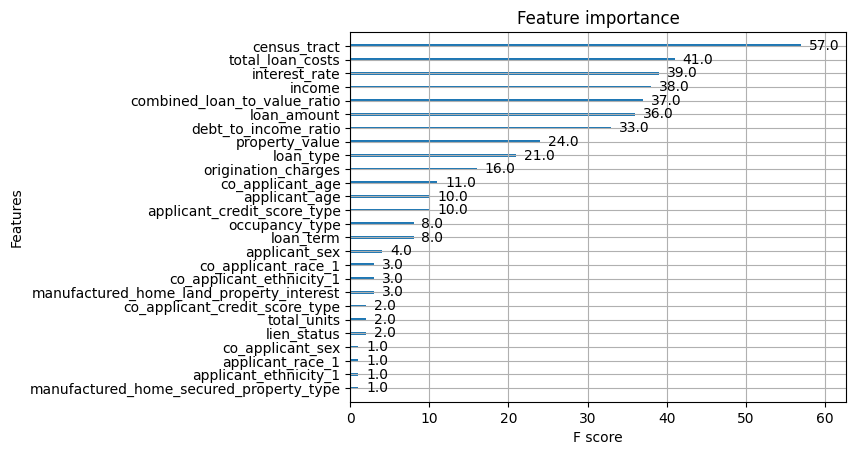

In [32]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Assuming xgb_model1 is your trained XGBoost model
xgb.plot_importance(xgb_model1)
plt.show()


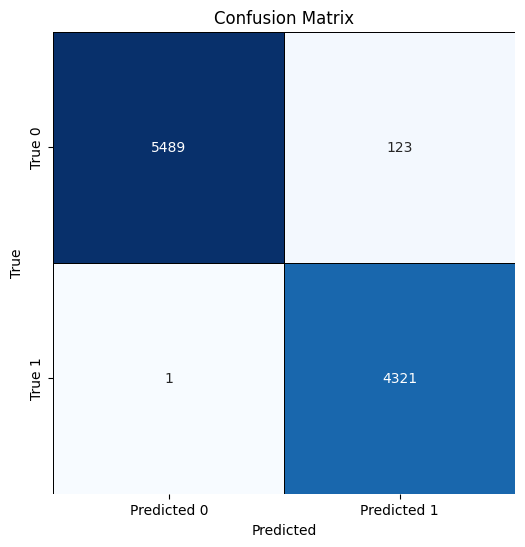

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming you already have y_test and y_predict from your code

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_predict)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5, linecolor="black", square=True, cbar=False,
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["True 0", "True 1"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Make test data for the webapp

We create a json file.
it contains 5 accepted rows and 5 declined rows.
We feed this to the form in our webapp to test predictions. 

In [34]:
accepted_counter = 0  # Initialize the accepted counter
dummy_data = []  # List to store the dummy data

for index, target_value in enumerate(y_test):
    if target_value == 1.0 and accepted_counter < 3:
        dummy_name = f"acceptedDummy{accepted_counter + 1}"
        print(index)
        dummy_row = X_test.iloc[index].copy()  # Create a copy of the row
        dummy_row['action_taken'] = 1.0  # Set the action_taken value to 1.0 for accepted
        dummy_data.append((dummy_name, dummy_row))
        accepted_counter += 1

dummy_data


0
3
6


[('acceptedDummy1',
  census_tract                                0.311689
  loan_type                                   0.000000
  lien_status                                 0.000000
  open_end_line_of_credit                     1.000000
  loan_amount                                 0.005882
  combined_loan_to_value_ratio                0.200000
  interest_rate                               0.333333
  total_loan_costs                            0.352941
  origination_charges                         0.000000
  loan_term                                   0.833333
  negative_amortization                       1.000000
  interest_only_payment                       1.000000
  balloon_payment                             1.000000
  other_nonamortizing_features                1.000000
  property_value                              0.004058
  occupancy_type                              0.000000
  manufactured_home_secured_property_type     1.000000
  manufactured_home_land_property_interest   

## Make a list of a few predictions and mirror them vs true labels.

In [35]:
X_test

,census_tract,loan_type,lien_status,open_end_line_of_credit,loan_amount,combined_loan_to_value_ratio,interest_rate,total_loan_costs,origination_charges,loan_term,...,applicant_ethnicity_1,co_applicant_ethnicity_1,applicant_race_1,applicant_race_2,co_applicant_race_1,co_applicant_race_2,applicant_sex,co_applicant_sex,applicant_age,co_applicant_age
8569,0.311689,0.0,0.0,1.0,0.005882,0.200000,0.333333,0.352941,0.000000,0.833333,...,1.0,1.0,1.0,0.0,1.0,0.093023,0.0,0.2,0.428571,0.428571
23113,0.145538,0.0,0.0,1.0,0.020000,0.066667,0.111111,0.000000,0.142857,0.333333,...,1.0,1.0,1.0,0.0,1.0,0.093023,0.2,0.0,0.142857,0.142857
26945,0.491117,0.0,0.0,1.0,0.010000,0.000000,0.444444,0.470588,0.000000,0.833333,...,1.0,1.0,1.0,0.0,1.0,0.093023,0.2,0.0,0.857143,0.857143
6483,0.981615,0.0,0.0,1.0,0.005882,0.066667,0.333333,0.352941,0.000000,0.166667,...,1.0,1.0,1.0,0.0,1.0,0.093023,0.0,0.2,0.428571,0.428571
29840,0.091501,0.0,0.0,1.0,0.013529,0.533333,0.444444,0.294118,0.428571,0.333333,...,1.0,1.0,1.0,0.0,1.0,0.093023,0.0,0.2,0.428571,0.285714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28628,0.800770,0.0,0.0,1.0,0.005882,0.533333,0.444444,0.000000,0.142857,0.833333,...,1.0,1.0,1.0,0.0,1.0,0.093023,0.0,0.2,0.428571,0.428571
1796,0.746158,0.0,0.0,1.0,0.006471,0.400000,0.333333,0.352941,0.000000,0.833333,...,1.0,1.0,1.0,0.0,1.0,0.093023,0.2,0.0,0.142857,0.857143
12635,0.091504,0.0,0.0,1.0,0.032353,0.066667,0.333333,0.352941,0.000000,0.833333,...,0.0,0.0,1.0,0.0,1.0,0.093023,0.0,0.2,0.142857,0.142857
33426,0.473465,0.0,0.0,1.0,0.015294,0.000000,0.222222,0.411765,0.571429,0.833333,...,1.0,1.0,1.0,0.0,1.0,0.093023,0.2,0.0,0.000000,0.000000


In [36]:
# Initialize lists to store predictions and true values
predictions = []
true_values = []

def make_predictions(xgb_model1, X_test, y_test, num_predictions=5):
    # Make predictions for the test dataset
    for _, testX in X_test.iterrows():
        yhat = xgb_model1.predict([testX.values])  # Make a one-step prediction
        predictions.append(yhat[0])  # Store the prediction

    # Make predictions for the true values
    for true_value in y_test:
        true_values.append(true_value)  # Store the true value

    # Return lists of predictions and true values
    return predictions[:num_predictions], true_values[:num_predictions]

# Example usage:
preds, true_vals = make_predictions(xgb_model1, X_test, y_test, num_predictions=5)

# Display the results
print("Predictions:", preds)
print("True Values:", true_vals)


Predictions: [1, 0, 0, 1, 0]
True Values: [1.0, 0.0, 0.0, 1.0, 0.0]


### See which rows are accepted.

In [67]:
# Create a DataFrame with predictions and true values
results_df = pd.DataFrame({'Predictions': predictions, 'True_Values': true_values})

# Filter rows where Predictions are 1 (accepted)
accepted_rows = results_df[results_df['Predictions'] == 1]

# Display the accepted rows
print(accepted_rows)

      Predictions  True_Values
0               1          1.0
3               1          1.0
6               1          1.0
17              1          1.0
26              1          1.0
...           ...          ...
9923            1          1.0
9925            1          1.0
9930            1          1.0
9931            1          1.0
9933            1          1.0

[4444 rows x 2 columns]


### Pick a specific accepted row and see its values.

In [38]:
import joblib
model_xgboost = joblib.load('xgboost_model.pkl') 

In [39]:
row = X_test.iloc[7]
true_label = y_test.iloc[7]

prediction = xgb_model1.predict([row])
if prediction == true_label:
    print("Model prediction is correct.", true_label)
else:
    print("Model prediction is incorrect.", true_label)

Model prediction is correct. 0.0


In [40]:
row = X_test.iloc[7]
true_label = y_test.iloc[7]

prediction = model_xgboost.predict([row])
if prediction == true_label:
    print("Model prediction is correct.", true_label)
else:
    print("Model prediction is incorrect.", true_label)

Model prediction is correct. 0.0


In [41]:
row = X_test.iloc[147]
print(row)
true_label = y_test.iloc[147]

prediction = xgb_model1.predict([row])
if prediction == true_label:
    print("Model prediction is correct.", true_label)
else:
    print("Model prediction is incorrect.", true_label)

census_tract                                0.091639
loan_type                                   0.000000
lien_status                                 0.000000
open_end_line_of_credit                     1.000000
loan_amount                                 0.022353
combined_loan_to_value_ratio                0.466667
interest_rate                               0.333333
total_loan_costs                            0.352941
origination_charges                         0.000000
loan_term                                   0.833333
negative_amortization                       1.000000
interest_only_payment                       1.000000
balloon_payment                             1.000000
other_nonamortizing_features                1.000000
property_value                              0.017391
occupancy_type                              0.000000
manufactured_home_secured_property_type     1.000000
manufactured_home_land_property_interest    1.000000
total_units                                 0.

In [42]:
row = X_test.iloc[147]
true_label = y_test.iloc[147]

prediction = model_xgboost.predict([row])
if prediction == true_label:
    print("Model prediction is correct.", true_label)
else:
    print("Model prediction is incorrect.", true_label)

Model prediction is correct. 1.0


In [43]:
# Ensure that data_values has the correct format and values
data_values = X_test.iloc[6]  # accept: 0,3,6
data_values

census_tract                                0.418420
loan_type                                   0.000000
lien_status                                 0.000000
open_end_line_of_credit                     1.000000
loan_amount                                 0.039412
combined_loan_to_value_ratio                0.333333
interest_rate                               0.333333
total_loan_costs                            0.352941
origination_charges                         0.000000
loan_term                                   0.833333
negative_amortization                       1.000000
interest_only_payment                       1.000000
balloon_payment                             1.000000
other_nonamortizing_features                1.000000
property_value                              0.021449
occupancy_type                              0.000000
manufactured_home_secured_property_type     1.000000
manufactured_home_land_property_interest    1.000000
total_units                                 0.

In [44]:
# problematic prediction
prediction2 = model_xgboost.predict([data_values])
print(prediction2)  # This should be 1 if data_values now match the expected format and values

[1]


In [45]:
row1 = X_test.iloc[147]
np.save('row1.npy', row1)
row1

census_tract                                0.091639
loan_type                                   0.000000
lien_status                                 0.000000
open_end_line_of_credit                     1.000000
loan_amount                                 0.022353
combined_loan_to_value_ratio                0.466667
interest_rate                               0.333333
total_loan_costs                            0.352941
origination_charges                         0.000000
loan_term                                   0.833333
negative_amortization                       1.000000
interest_only_payment                       1.000000
balloon_payment                             1.000000
other_nonamortizing_features                1.000000
property_value                              0.017391
occupancy_type                              0.000000
manufactured_home_secured_property_type     1.000000
manufactured_home_land_property_interest    1.000000
total_units                                 0.

In [46]:
# correct prediction
prediction1 = model_xgboost.predict([row1])
print(prediction1)

[1]


# Pickle models

In [47]:
lr_model = linear_model.LogisticRegression(solver="lbfgs", random_state=random_state)
dt_model = tree.DecisionTreeClassifier(max_depth=8)
ADA_model = AdaBoostClassifier(n_estimators=50, random_state=random_state)
SGD_model = make_pipeline(StandardScaler(),
                     SGDClassifier(max_iter=100, tol=1e-3))

models = ["lr_model","dt_model","ADA_model","SGD_model"]

In [48]:
for model_name in models:
    
    curr_model = eval(model_name)
    
    curr_model.fit(X_train, y_train)
    
    with open(f"{model_name}.pickle", "wb") as pfile:
        pickle.dump(curr_model, pfile)

C:\Users\asche\anaconda3\envs\Test\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [49]:
model_names = ["lr_model","dt_model","ADA_model","SGD_model"]

for model_name in model_names:
    with open(f"{model_name}.pickle", "rb") as pfile:
        exec(f"{model_name} = pickle.load(pfile)")

model_vars = [eval(n) for n in model_names]
model_list = list(zip(model_names, model_vars))

In [50]:
for model_name in model_names:
    curr_model = eval(model_name)
    print(f'{model_name} score: {curr_model.score(X_train, y_train)}')
    print(f'{model_name} score: {curr_model.score(X_val, y_val)}')

lr_model score: 0.8534038001761671
lr_model score: 0.8451182687468546
dt_model score: 0.9846797533660501
dt_model score: 0.9849018621036739
ADA_model score: 0.9846797533660501
ADA_model score: 0.9846502264720685
SGD_model score: 0.8969737007675852
SGD_model score: 0.8943130347257172


# voting classifer (HARD)

In [51]:
voting_classifer = VotingClassifier(estimators=model_list,
                                    voting='hard', #<-- sklearn calls this hard voting
                                    n_jobs=-1)
voting_classifer.fit(X_train, y_train)

VotingClassifier(estimators=[('lr_model', LogisticRegression(random_state=42)),
                             ('dt_model', DecisionTreeClassifier(max_depth=8)),
                             ('ADA_model', AdaBoostClassifier(random_state=42)),
                             ('SGD_model',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('sgdclassifier',
                                               SGDClassifier(max_iter=100))]))],
                 n_jobs=-1)

In [52]:
y_pred = voting_classifer.predict(X_train)
accuracy_score(y_train, y_pred)

0.9843337108342771

In [53]:
y_pred = voting_classifer.predict(X_val)
accuracy_score(y_val, y_pred)

0.9842727730246603

# Compare all the models.

In [54]:
# Example model and prediction data
models = ['LR', 'knn', 'Ada Boost', 'Gaussian', 'Stochastic Gradient Descent', 'xgb_model1', 'Decision Tree', 'SGD_model', 'voting_classifier']
y_pred1 = LR.predict(X_val)
y_pred2 = knn.predict(X_val)
y_pred3 = AB_CLF.predict(X_val)
y_pred4 = Gaussian.predict(X_val)
y_pred5 = SG_PIP_CLF.predict(X_val)
y_pred6 = xgb_model1.predict(X_val)
y_pred7 = dt_model.predict(X_val)
y_pred8 = SGD_model.predict(X_val)
y_pred9 = voting_classifer.predict(X_val)  
 

y_true = y_val  # True labels

# Calculate evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

metrics = {
    'Accuracy': [accuracy_score(y_true, y_pred1), accuracy_score(y_true, y_pred2), accuracy_score(y_true, y_pred3),
                 accuracy_score(y_true, y_pred4), accuracy_score(y_true, y_pred5), accuracy_score(y_true, y_pred6),
                 accuracy_score(y_true, y_pred7), accuracy_score(y_true, y_pred8), accuracy_score(y_true, y_pred9)],
    
    'Precision': [precision_score(y_true, y_pred1), precision_score(y_true, y_pred2), precision_score(y_true, y_pred3),
                  precision_score(y_true, y_pred4), precision_score(y_true, y_pred5), precision_score(y_true, y_pred6),
                  precision_score(y_true, y_pred7), precision_score(y_true, y_pred8), precision_score(y_true, y_pred9)],
    
    'Recall': [recall_score(y_true, y_pred1), recall_score(y_true, y_pred2), recall_score(y_true, y_pred3),
               recall_score(y_true, y_pred4), recall_score(y_true, y_pred5), recall_score(y_true, y_pred6),
               recall_score(y_true, y_pred7), recall_score(y_true, y_pred8), recall_score(y_true, y_pred9)],
    
    'F1 Score': [f1_score(y_true, y_pred1), f1_score(y_true, y_pred2), f1_score(y_true, y_pred3),
                 f1_score(y_true, y_pred4), f1_score(y_true, y_pred5), f1_score(y_true, y_pred6),
                 f1_score(y_true, y_pred7), f1_score(y_true, y_pred8), f1_score(y_true, y_pred9)]
}

# Create a DataFrame
import pandas as pd
df = pd.DataFrame(metrics, index=models)

# Display the DataFrame
print(df)


                             Accuracy  Precision    Recall  F1 Score
LR                           0.845244   0.766650  0.921145  0.836827
knn                          0.876447   0.802527  0.945970  0.868365
Ada Boost                    0.984650   0.965595  1.000000  0.982496
Gaussian                     0.792275   0.990592  0.522780  0.684382
Stochastic Gradient Descent  0.889658   0.805616  0.980432  0.884468
xgb_model1                   0.984776   0.966130  0.999708  0.982632
Decision Tree                0.984902   0.966140  1.000000  0.982778
SGD_model                    0.894313   0.805005  0.995911  0.890339
voting_classifier            0.984273   0.965829  0.998832  0.982053
